In [0]:
# header files
import numpy as np
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset
import cv2
import glob
from torch.autograd import Variable
import torchvision.models as models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder("/content/drive/My Drive/train_images/", transform=train_transforms)
val_data = datasets.ImageFolder("/content/drive/My Drive/val_images/", transform=train_transforms)
print(len(train_data))
print(len(val_data))

18852
6148


In [0]:
# loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=16, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True, num_workers=16, pin_memory=True)

In [0]:
# define VGG16 network
class VGG16(nn.Module):
    
    # init method
    def __init__(self, num_classes = 2):
        super(VGG16, self).__init__()
        
        self.features = nn.Sequential(
            
            # first cnn block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # second cnn block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # third cnn block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # fourth cnn block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # fifth cnn block
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
            nn.LogSoftmax(dim=1)
        )
    
    # forward step
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [0]:
# define loss
criterion = nn.NLLLoss()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16()
model.to(device)

VGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 2

In [0]:
# optimizer to be used
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)

In [0]:
train_losses = []
train_acc = []
val_losses = []
val_acc = []

# train and validate
for epoch in range(0, 40):
    
    # train
    model.train()
    training_loss = 0.0
    total = 0
    correct = 0
    for i, (input, target) in enumerate(train_loader):
        
        input = input.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        training_loss = training_loss + loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
    training_loss = training_loss / float(len(train_loader))
    training_accuracy = str(100.0 * (float(correct) / float(total)))
    train_losses.append(training_loss)
    train_acc.append(training_accuracy)
    
    # validate
    model.eval()
    valid_loss = 0.0
    total = 0
    correct = 0
    for i, (input, target) in enumerate(val_loader):
        
        with torch.no_grad():
            input = input.to(device)
            target = target.to(device)

            output = model(input)
            loss = criterion(output, target)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            
        valid_loss = valid_loss + loss.item()
    valid_loss = valid_loss / float(len(val_loader))
    valid_accuracy = str(100.0 * (float(correct) / float(total)))
    val_losses.append(valid_loss)
    val_acc.append(valid_accuracy)
    
    print()
    print("Epoch" + str(epoch) + ":")
    print("Training Accuracy: " + str(training_accuracy) + "    Validation Accuracy: " + str(valid_accuracy))
    print("Training Loss: " + str(training_loss) + "    Validation Loss: " + str(valid_loss))
    print()


Epoch0:
Training Accuracy: 51.95204752811373    Validation Accuracy: 41.37931034482759
Training Loss: 3.1189721182241277    Validation Loss: 0.7105010489827579


Epoch1:
Training Accuracy: 51.98917886696371    Validation Accuracy: 41.37931034482759
Training Loss: 0.6931060126272298    Validation Loss: 0.7226569160972673


Epoch2:
Training Accuracy: 52.32866539359219    Validation Accuracy: 41.37931034482759
Training Loss: 0.6925098324226121    Validation Loss: 0.7245780426202361



In [0]:
import matplotlib.pyplot as plt
epochs = []
for index in range(0, 40):
  epochs.append(index)

print(len(epochs))
print(len(train_losses))
print(len(val_losses))
print(len(train_acc))
print(len(val_acc))

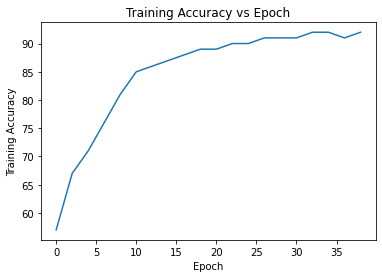

In [26]:
x = []
y = []
for index in range(0, 40, 2):
  x.append(epochs[index])
  train_acc[index] = int(float(train_acc[index]))
  y.append(train_acc[index])

plt.title("Training Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.plot(x, y)
#plt.show()
plt.savefig("/content/drive/My Drive/case2_1.png")

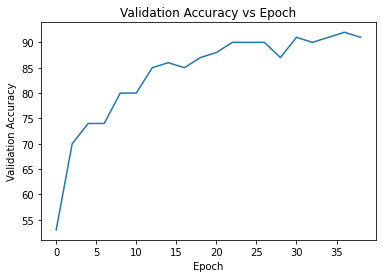

In [25]:
import numpy as np
x = []
y = []
for index in range(0, 40, 2):
  x.append(epochs[index])
  val_acc[index] = int(float(val_acc[index]))
  y.append(val_acc[index])

plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.plot(x, y)
#plt.show()
plt.savefig("/content/drive/My Drive/case2_2.png")

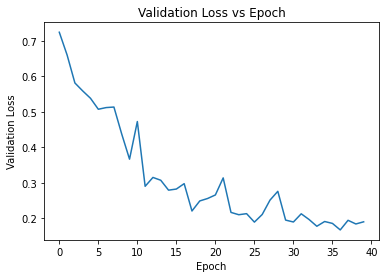

In [28]:
plt.title("Validation Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.plot(epochs, val_losses)
#plt.show()
plt.savefig("/content/drive/My Drive/case2_3.png")

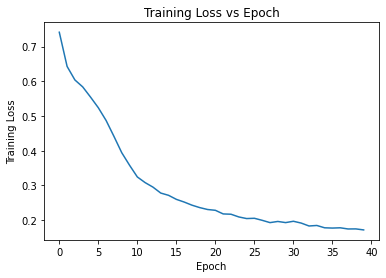

In [14]:
plt.title("Training Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.plot(epochs, train_losses)
#plt.show()
plt.savefig("/content/drive/My Drive/case2_4.png")

In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/model_case2.pth')